In [1]:
# crypto_backtest.ipynb – setup

import os
from pathlib import Path

import numpy as np
import pandas as pd

# Notebook CWD is PREDICTION-MARKET-MONEY-PRINTER/notebooks
BASE_DIR = Path("..").resolve()
DATA_DIR = BASE_DIR / "data"
TRADES_DIR = BASE_DIR / "kalshi_fetcher" / "data" / "enriched_trades"

print("CWD:      ", os.getcwd())
print("BASE_DIR: ", BASE_DIR)
print("DATA_DIR: ", DATA_DIR)
print("TRADES_DIR:", TRADES_DIR)


CWD:       c:\Users\Adam Nhan\prediction-market-money-printer\notebooks
BASE_DIR:  C:\Users\Adam Nhan\prediction-market-money-printer
DATA_DIR:  C:\Users\Adam Nhan\prediction-market-money-printer\data
TRADES_DIR: C:\Users\Adam Nhan\prediction-market-money-printer\kalshi_fetcher\data\enriched_trades


In [2]:
# Step 2: Load enriched markets and filter to Crypto only

enriched_path = DATA_DIR / "enriched_markets.csv"
enriched_df = pd.read_csv(enriched_path)

# Keep only markets categorized as Crypto
crypto_df = enriched_df[enriched_df["category"] == "Crypto"].copy()

print("Total markets:", len(enriched_df))
print("Crypto markets:", len(crypto_df))
crypto_df.head(3)


Total markets: 800
Crypto markets: 400


,ticker,event_ticker,category,normalized_status,status,close_time,volume,last_price,result,settlement_value,title,category_event,series_ticker,event_time
400,KXETHD-25NOV0913-T4139.99,KXETHD-25NOV0913,Crypto,settled,finalized,2025-11-09T18:00:00Z,0,0,no,0,"Ethereum price on Nov 9, 2025 at 1pm EST?",Crypto,KXETHD,2025-11-09T18:00:00Z
401,KXETHD-25NOV0913-T4119.99,KXETHD-25NOV0913,Crypto,settled,finalized,2025-11-09T18:00:00Z,0,0,no,0,"Ethereum price on Nov 9, 2025 at 1pm EST?",Crypto,KXETHD,2025-11-09T18:00:00Z
402,KXETHD-25NOV0913-T4099.99,KXETHD-25NOV0913,Crypto,settled,finalized,2025-11-09T18:00:00Z,0,0,no,0,"Ethereum price on Nov 9, 2025 at 1pm EST?",Crypto,KXETHD,2025-11-09T18:00:00Z


In [3]:
# Step 3 (fixed): load combined_v4 with all engineered features

combined_v4_path = DATA_DIR / "combined_v4.csv"
combined_v4 = pd.read_csv(combined_v4_path)

# Crypto-only slice from the fully-featured table
crypto_df = combined_v4[combined_v4["category"] == "Crypto"].copy()

X_cols_v5 = [
    # existing features
    "direction_agreement", "burstiness", "last_minute_ratio", "velocity_price_change",
    "relative_volatility", "inter_dir_burst", "inter_dir_last",
    "ratio_vol_1m_30m", "ratio_vol_3m_30m", "price_change_1m", "price_change_3m",
    # new derived features
    "accel_ratio", "price_momentum_diff", "burstiness_dev",
    "vol_surge_3m", "price_vol_1m_interaction"
]

X_crypto = crypto_df[X_cols_v5].fillna(0)
y_crypto = crypto_df["is_yes"].astype(int)

print("Crypto combined_v4 shape:", crypto_df.shape)
print("Feature matrix shape:", X_crypto.shape)
print("Target distribution:\n", y_crypto.value_counts())


Crypto combined_v4 shape: (200, 35)
Feature matrix shape: (200, 16)
Target distribution:
 is_yes
0    128
1     72
Name: count, dtype: int64


In [4]:
# Step 4: Fit Crypto-only logistic regression (same setup as v2)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# Train/test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_crypto, y_crypto,
    test_size=0.3,
    random_state=42,
    stratify=y_crypto
)

# Logistic Regression pipeline
log_model_crypto = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

log_model_crypto.fit(X_train_c, y_train_c)

# Evaluate
y_proba_test = log_model_crypto.predict_proba(X_test_c)[:, 1]
y_pred_test = (y_proba_test >= 0.5).astype(int)

auc = roc_auc_score(y_test_c, y_proba_test)
acc = accuracy_score(y_test_c, y_pred_test)

print(f"Crypto Logistic ROC-AUC: {auc:.3f}")
print(f"Crypto Logistic Accuracy: {acc:.3f}")


Crypto Logistic ROC-AUC: 0.759
Crypto Logistic Accuracy: 0.733


In [5]:
# Step 5: Refit on all Crypto data for backtesting predictions

final_log_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)
final_log_model.fit(X_crypto, y_crypto)

# Predicted probability P(YES) per market
crypto_df["model_p_yes"] = final_log_model.predict_proba(X_crypto)[:, 1]

print("Added model_p_yes column.")
crypto_df[["ticker", "model_p_yes"]].head()


Added model_p_yes column.


,ticker,model_p_yes
208,KXBTCD-25NOV0911-T103749.99,0.995933
209,KXBTCD-25NOV0913-T103499.99,0.931837
210,KXBTCD-25NOV0912-T103749.99,0.895981
211,KXBTCD-25NOV0912-T103499.99,0.430397
212,KXBTCD-25NOV0909-T102749.99,0.641131


In [21]:
# Step 7: helper – last trade price before event_time → market-implied P(YES)

import numpy as np
import pandas as pd

def get_market_prob_from_trades(row, event_time_col=EVENT_TIME_COL):
    ticker = row["ticker"]
    event_time = pd.to_datetime(row[event_time_col], utc=True)

    path = TRADES_DIR / f"{ticker}.csv"
    if not path.exists():
        return np.nan

    df = pd.read_csv(path)
    if df.empty:
        return np.nan

    # We expect a timestamp column for trades
    if "created_time" not in df.columns:
        return np.nan

    df["created_time"] = pd.to_datetime(df["created_time"], utc=True)

    # Only use trades up to the event time
    df_pre = df[df["created_time"] <= event_time]
    if df_pre.empty:
        return np.nan

    # Pick a price column (adjust name here if needed)
    price_col = "price"
    if price_col not in df_pre.columns:
        for cand in ["yes_price", "last_price", "trade_price"]:
            if cand in df_pre.columns:
                price_col = cand
                break
        else:
            return np.nan

    # Last trade before event_time
    last_price = df_pre.sort_values("created_time")[price_col].iloc[-1]

    # Convert 0–100 style prices to 0–1 probabilities if needed
    if last_price > 1.0:
        last_price = last_price / 100.0

    return float(last_price)


In [10]:
# Microstep: merge event_time from enriched_df into crypto_df

EVENT_TIME_COL = "event_time"

crypto_df = crypto_df.merge(
    enriched_df[["ticker", EVENT_TIME_COL]],
    on="ticker",
    how="left"
)

crypto_df[["ticker", EVENT_TIME_COL]].head()



,ticker,event_time
0,KXBTCD-25NOV0911-T103749.99,2025-11-09T16:00:00Z
1,KXBTCD-25NOV0913-T103499.99,2025-11-09T18:00:00Z
2,KXBTCD-25NOV0912-T103749.99,2025-11-09T17:00:00Z
3,KXBTCD-25NOV0912-T103499.99,2025-11-09T17:00:00Z
4,KXBTCD-25NOV0909-T102749.99,2025-11-09T14:00:00Z


In [11]:
# Microstep: compute market-implied probability from last pre-event trade

from tqdm import tqdm
tqdm.pandas()

crypto_df["market_prob"] = crypto_df.progress_apply(
    get_market_prob_from_trades, axis=1
)

crypto_df[["ticker", "model_p_yes", "market_prob"]].head(10)


100%|██████████| 200/200 [00:02<00:00, 94.18it/s] 


,ticker,model_p_yes,market_prob
0,KXBTCD-25NOV0911-T103749.99,0.995933,0.99
1,KXBTCD-25NOV0913-T103499.99,0.931837,0.99
2,KXBTCD-25NOV0912-T103749.99,0.895981,0.99
3,KXBTCD-25NOV0912-T103499.99,0.430397,0.98
4,KXBTCD-25NOV0909-T102749.99,0.641131,0.99
5,KXBTCD-25NOV0910-T102749.99,0.284671,0.63
6,KXBTCD-25NOV0912-T103249.99,0.538222,0.99
7,KXBTCD-25NOV0909-T102499.99,0.448079,0.97
8,KXBTCD-25NOV0911-T103499.99,0.490780,0.97
9,KXBTC-25NOV0820-B101875,0.956412,0.99


In [12]:
# Microstep: compute signal difference between model and market

crypto_df["signal_diff"] = crypto_df["model_p_yes"] - crypto_df["market_prob"]
crypto_df[["ticker", "model_p_yes", "market_prob", "signal_diff"]].head(10)


,ticker,model_p_yes,market_prob,signal_diff
0,KXBTCD-25NOV0911-T103749.99,0.995933,0.99,0.005933
1,KXBTCD-25NOV0913-T103499.99,0.931837,0.99,-0.058163
2,KXBTCD-25NOV0912-T103749.99,0.895981,0.99,-0.094019
3,KXBTCD-25NOV0912-T103499.99,0.430397,0.98,-0.549603
4,KXBTCD-25NOV0909-T102749.99,0.641131,0.99,-0.348869
5,KXBTCD-25NOV0910-T102749.99,0.284671,0.63,-0.345329
6,KXBTCD-25NOV0912-T103249.99,0.538222,0.99,-0.451778
7,KXBTCD-25NOV0909-T102499.99,0.448079,0.97,-0.521921
8,KXBTCD-25NOV0911-T103499.99,0.490780,0.97,-0.479220
9,KXBTC-25NOV0820-B101875,0.956412,0.99,-0.033588


In [27]:
# Microstep: define trading rule based on model–market difference

THRESHOLD = 0.2  # adjust later

def decide_trade(row):
    if row["signal_diff"] > THRESHOLD:
        return "LONG_YES"
    elif row["signal_diff"] < -THRESHOLD:
        return "LONG_NO"
    else:
        return "NO_TRADE"

crypto_df["position"] = crypto_df.apply(decide_trade, axis=1)
crypto_df["position"].value_counts()


position
LONG_NO     70
NO_TRADE    69
LONG_YES    61
Name: count, dtype: int64

In [28]:
# Microstep: compute per-market PnL (1-contract trades, 0–1 price scale)

import numpy as np

def compute_pnl(row):
    # Skip if we don't have a market price
    if np.isnan(row["market_prob"]):
        return np.nan

    outcome_yes = row["is_yes"]          # 1 if YES settles, else 0
    price_yes = row["market_prob"]      # entry price for YES in 0–1
    price_no = 1.0 - price_yes          # implied NO price
    outcome_no = 1 - outcome_yes        # 1 if NO settles, else 0

    if row["position"] == "LONG_YES":
        return outcome_yes - price_yes          # payoff - cost
    elif row["position"] == "LONG_NO":
        return outcome_no - price_no
    else:
        return 0.0  # no trade

crypto_df["pnl_1_contract"] = crypto_df.apply(compute_pnl, axis=1)
crypto_df[["ticker", "position", "market_prob", "is_yes", "pnl_1_contract"]].head(10)


,ticker,position,market_prob,is_yes,pnl_1_contract
0,KXBTCD-25NOV0911-T103749.99,NO_TRADE,0.99,1,0.00
1,KXBTCD-25NOV0913-T103499.99,NO_TRADE,0.99,1,0.00
2,KXBTCD-25NOV0912-T103749.99,NO_TRADE,0.99,1,0.00
3,KXBTCD-25NOV0912-T103499.99,LONG_NO,0.98,1,-0.02
4,KXBTCD-25NOV0909-T102749.99,LONG_NO,0.99,1,-0.01
5,KXBTCD-25NOV0910-T102749.99,LONG_NO,0.63,1,-0.37
6,KXBTCD-25NOV0912-T103249.99,LONG_NO,0.99,1,-0.01
7,KXBTCD-25NOV0909-T102499.99,LONG_NO,0.97,1,-0.03
8,KXBTCD-25NOV0911-T103499.99,LONG_NO,0.97,1,-0.03
9,KXBTC-25NOV0820-B101875,NO_TRADE,0.99,1,0.00


In [29]:
# Microstep: summarize backtest results

summary = {
    "total_trades": (crypto_df["position"] != "NO_TRADE").sum(),
    "total_pnl": crypto_df["pnl_1_contract"].sum(),
    "avg_pnl_per_trade": crypto_df.loc[crypto_df["position"] != "NO_TRADE", "pnl_1_contract"].mean(),
    "hit_rate": (crypto_df.loc[crypto_df["pnl_1_contract"] > 0, "pnl_1_contract"].count()) /
                (crypto_df["position"] != "NO_TRADE").sum(),
}

for k, v in summary.items():
    print(f"{k:20s} {v:.4f}")


total_trades         131.0000
total_pnl            5.2200
avg_pnl_per_trade    0.0398
hit_rate             0.1298


In [30]:
# Microstep: PnL vs threshold sweep

thresholds = np.linspace(0.01, 0.50, 20)
results = []

for t in thresholds:
    crypto_df["position_tmp"] = np.select(
        [crypto_df["signal_diff"] > t, crypto_df["signal_diff"] < -t],
        ["LONG_YES", "LONG_NO"],
        default="NO_TRADE"
    )
    pnl = crypto_df.apply(compute_pnl, axis=1)
    results.append({
        "threshold": t,
        "total_pnl": pnl.sum(),
        "avg_pnl": pnl[crypto_df["position_tmp"] != "NO_TRADE"].mean()
    })

pd.DataFrame(results)


,threshold,total_pnl,avg_pnl
0,0.010000,5.22,0.026633
1,0.035789,5.22,0.027619
2,0.061579,5.22,0.028840
3,0.087368,5.22,0.029829
4,0.113158,5.22,0.030526
5,0.138947,5.22,0.032625
6,0.164737,5.22,0.036000
7,0.190526,5.22,0.038102
8,0.216316,5.22,0.036935
9,0.242105,5.22,0.052000


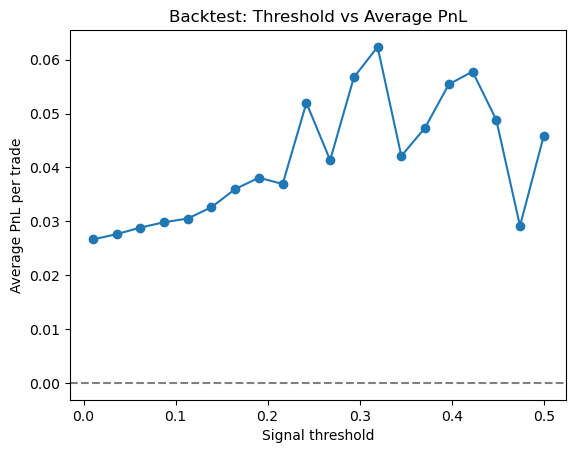

In [31]:
# Microstep: plot threshold vs average PnL
import matplotlib.pyplot as plt

df_thresh = pd.DataFrame(results)

plt.plot(df_thresh["threshold"], df_thresh["avg_pnl"], marker="o")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Signal threshold")
plt.ylabel("Average PnL per trade")
plt.title("Backtest: Threshold vs Average PnL")
plt.show()


In [32]:
# Microstep: see how many trades remain at profitable thresholds

for t in [0.07, 0.10, 0.15, 0.20, 0.30]:
    active = (crypto_df["signal_diff"].abs() > t).sum()
    print(f"Threshold {t:.2f}: {active} trades")


Threshold 0.07: 178 trades
Threshold 0.10: 174 trades
Threshold 0.15: 152 trades
Threshold 0.20: 131 trades
Threshold 0.30: 94 trades


In [7]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

# Notebook CWD is PREDICTION-MARKET-MONEY-PRINTER/notebooks
BASE_DIR = Path("..").resolve()
DATA_DIR = BASE_DIR / "data"
TRADES_DIR = BASE_DIR / "kalshi_fetcher" / "data" / "enriched_trades"
new_enriched = pd.read_csv(DATA_DIR / "enriched_markets.csv")
print(new_enriched["category"].value_counts().head())


category
Crypto    1000
Name: count, dtype: int64


In [9]:
# Microstep: verify working directory and file path
import os
from pathlib import Path

DATA_DIR = Path("..") / "data"
print("Current working dir:", os.getcwd())

# List all CSV files in the data folder
for f in DATA_DIR.glob("*.csv"):
    print("-", f.name)



Current working dir: c:\Users\Adam Nhan\prediction-market-money-printer\notebooks
- closed_markets.csv
- combined_v4.csv
- combined_v4_new.csv
- enriched_markets.csv
- events.csv
- features.csv
- flagged_summary_20251107.csv
- flagged_summary_20251108.csv
- suspicious_markets_20251107.csv
- suspicious_markets_20251108.csv


In [10]:
# Microstep: load combined_v4_new.csv and inspect
import pandas as pd

combined_v4_new_path = DATA_DIR / "combined_v4_new.csv"
combined_v4_new = pd.read_csv(combined_v4_new_path)

print("Rows:", len(combined_v4_new))
print("Columns:", len(combined_v4_new.columns))
combined_v4_new.head(3)


Rows: 1000
Columns: 35


,ticker,category,event_ticker,late_volume_ratio,abs_price_jump,yes_flow_ratio,price_std_1h,vol_total,vol_5m,vol_10m,...,vol_3m,price_change_1m,price_change_3m,ratio_vol_1m_30m,ratio_vol_3m_30m,accel_ratio,price_momentum_diff,burstiness_dev,vol_surge_3m,price_vol_1m_interaction
0,KXBTCD-25NOV1017-T99999.99,Crypto,KXBTCD-25NOV1017,0.0,0.0,0.0,0.0,184,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.383069,0.0,0.0
1,KXBTCD-25NOV1017-T99499.99,Crypto,KXBTCD-25NOV1017,0.0,0.0,0.0,0.0,32,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.383069,0.0,0.0
2,KXBTCD-25NOV1017-T98999.99,Crypto,KXBTCD-25NOV1017,0.0,0.0,0.0,0.0,8,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.383069,0.0,0.0


In [12]:
# Microstep: redefine the v5 feature list used by the model

X_cols_v5 = [
    "direction_agreement", "burstiness", "last_minute_ratio", "velocity_price_change",
    "relative_volatility", "inter_dir_burst", "inter_dir_last",
    "ratio_vol_1m_30m", "ratio_vol_3m_30m", "price_change_1m", "price_change_3m",
    "accel_ratio", "price_momentum_diff", "burstiness_dev",
    "vol_surge_3m", "price_vol_1m_interaction"
]

print("Feature count:", len(X_cols_v5))



Feature count: 16


In [13]:
crypto_new = combined_v4_new[combined_v4_new["category"] == "Crypto"].copy()
X_new = crypto_new[X_cols_v5].fillna(0)

print("New Crypto rows:", len(crypto_new))
print("X_new shape:", X_new.shape)
crypto_new[["ticker"]].head()



New Crypto rows: 1000
X_new shape: (1000, 16)


,ticker
0,KXBTCD-25NOV1017-T99999.99
1,KXBTCD-25NOV1017-T99499.99
2,KXBTCD-25NOV1017-T98999.99
3,KXBTCD-25NOV1017-T98499.99
4,KXBTCD-25NOV1017-T97999.99


In [14]:
# Microstep: apply trained Crypto model to new data

# Assumes final_log_model is already defined (from your earlier backtest notebook section)
crypto_new["model_p_yes"] = final_log_model.predict_proba(X_new)[:, 1]

print("Added model_p_yes to new Crypto markets.")
crypto_new[["ticker", "model_p_yes"]].head()


NameError: name 'final_log_model' is not defined

In [16]:
# Microstep: reload original Crypto training data and retrain model

import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Load original combined_v4.csv (old training data)
combined_v4_path = DATA_DIR / "combined_v4.csv"
combined_v4_old = pd.read_csv(combined_v4_path)

# Recreate training set for Crypto
crypto_old = combined_v4_old[combined_v4_old["category"] == "Crypto"].copy()

X_cols_v5 = [
    "direction_agreement", "burstiness", "last_minute_ratio", "velocity_price_change",
    "relative_volatility", "inter_dir_burst", "inter_dir_last",
    "ratio_vol_1m_30m", "ratio_vol_3m_30m", "price_change_1m", "price_change_3m",
    "accel_ratio", "price_momentum_diff", "burstiness_dev",
    "vol_surge_3m", "price_vol_1m_interaction"
]

X_crypto = crypto_old[X_cols_v5].fillna(0)
y_crypto = crypto_old["is_yes"].astype(int)

# Fit the logistic regression
final_log_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)
final_log_model.fit(X_crypto, y_crypto)

print("Refit Crypto logistic model on original data. Ready to predict on new dataset.")


Refit Crypto logistic model on original data. Ready to predict on new dataset.


In [17]:
# Microstep: recreate and refit the Crypto logistic regression model

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

final_log_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

# Fit on your original (old) Crypto data from combined_v4.csv
# If you still have it in memory as crypto_df and X_crypto/y_crypto:
final_log_model.fit(X_crypto, y_crypto)

print("Refit Crypto logistic model on original dataset.")


Refit Crypto logistic model on original dataset.


In [18]:
# Microstep: apply trained Crypto model to new data

# Assumes final_log_model is already defined (from your earlier backtest notebook section)
crypto_new["model_p_yes"] = final_log_model.predict_proba(X_new)[:, 1]

print("Added model_p_yes to new Crypto markets.")
crypto_new[["ticker", "model_p_yes"]].head()


Added model_p_yes to new Crypto markets.


,ticker,model_p_yes
0,KXBTCD-25NOV1017-T99999.99,0.377142
1,KXBTCD-25NOV1017-T99499.99,0.377142
2,KXBTCD-25NOV1017-T98999.99,0.377142
3,KXBTCD-25NOV1017-T98499.99,0.377142
4,KXBTCD-25NOV1017-T97999.99,0.377142


In [19]:
# Microstep: merge updated event_time into crypto_new

enriched_new = pd.read_csv(DATA_DIR / "enriched_markets.csv")

EVENT_TIME_COL = "event_time"

crypto_new = crypto_new.merge(
    enriched_new[["ticker", EVENT_TIME_COL]],
    on="ticker",
    how="left"
)

crypto_new[["ticker", EVENT_TIME_COL, "model_p_yes"]].head()


,ticker,event_time,model_p_yes
0,KXBTCD-25NOV1017-T99999.99,2025-11-10T22:00:00Z,0.377142
1,KXBTCD-25NOV1017-T99499.99,2025-11-10T22:00:00Z,0.377142
2,KXBTCD-25NOV1017-T98999.99,2025-11-10T22:00:00Z,0.377142
3,KXBTCD-25NOV1017-T98499.99,2025-11-10T22:00:00Z,0.377142
4,KXBTCD-25NOV1017-T97999.99,2025-11-10T22:00:00Z,0.377142


In [23]:
# Redefine helper: handle ISO8601 timestamps robustly

import numpy as np
import pandas as pd

def get_market_prob_from_trades(row, event_time_col=EVENT_TIME_COL):
    ticker = row["ticker"]

    # Robust parse of event_time
    event_time_raw = row[event_time_col]
    if pd.isna(event_time_raw):
        return np.nan

    event_time = pd.to_datetime(event_time_raw, format="ISO8601", utc=True, errors="coerce")
    if pd.isna(event_time):
        return np.nan

    path = TRADES_DIR / f"{ticker}.csv"
    if not path.exists():
        return np.nan

    df = pd.read_csv(path)
    if df.empty:
        return np.nan

    if "created_time" not in df.columns:
        return np.nan

    # Robust parse of trade timestamps
    df["created_time"] = pd.to_datetime(
        df["created_time"],
        format="ISO8601",
        utc=True,
        errors="coerce"
    )
    df = df.dropna(subset=["created_time"])

    # Only trades up to event_time
    df_pre = df[df["created_time"] <= event_time]
    if df_pre.empty:
        return np.nan

    # Choose price column
    price_col = "price"
    if price_col not in df_pre.columns:
        for cand in ["yes_price", "last_price", "trade_price"]:
            if cand in df_pre.columns:
                price_col = cand
                break
        else:
            return np.nan

    last_price = df_pre.sort_values("created_time")[price_col].iloc[-1]

    # Convert 0–100 to 0–1 if needed
    if last_price > 1.0:
        last_price = last_price / 100.0

    return float(last_price)


In [24]:
# Microstep: compute market-implied probability from new enriched trades

from tqdm import tqdm
tqdm.pandas()

crypto_new["market_prob"] = crypto_new.progress_apply(
    get_market_prob_from_trades, axis=1
)

crypto_new[["ticker", "model_p_yes", "market_prob"]].head(10)


100%|██████████| 1000/1000 [00:03<00:00, 328.46it/s]


,ticker,model_p_yes,market_prob
0,KXBTCD-25NOV1017-T99999.99,0.377142,0.96
1,KXBTCD-25NOV1017-T99499.99,0.377142,0.86
2,KXBTCD-25NOV1017-T98999.99,0.377142,0.72
3,KXBTCD-25NOV1017-T98499.99,0.377142,0.72
4,KXBTCD-25NOV1017-T97999.99,0.377142,0.72
5,KXBTCD-25NOV1017-T97499.99,0.377142,0.50
6,KXBTCD-25NOV1017-T96999.99,0.377142,0.50
7,KXBTCD-25NOV1017-T96499.99,0.377142,0.50
8,KXBTCD-25NOV1017-T95999.99,0.377142,0.50
9,KXBTCD-25NOV1017-T105499.99,0.980857,0.99


In [25]:
# Microstep: compute model–market signal difference on NEW data

crypto_new["signal_diff"] = crypto_new["model_p_yes"] - crypto_new["market_prob"]

crypto_new[["ticker", "model_p_yes", "market_prob", "signal_diff"]].head(10)


,ticker,model_p_yes,market_prob,signal_diff
0,KXBTCD-25NOV1017-T99999.99,0.377142,0.96,-0.582858
1,KXBTCD-25NOV1017-T99499.99,0.377142,0.86,-0.482858
2,KXBTCD-25NOV1017-T98999.99,0.377142,0.72,-0.342858
3,KXBTCD-25NOV1017-T98499.99,0.377142,0.72,-0.342858
4,KXBTCD-25NOV1017-T97999.99,0.377142,0.72,-0.342858
5,KXBTCD-25NOV1017-T97499.99,0.377142,0.50,-0.122858
6,KXBTCD-25NOV1017-T96999.99,0.377142,0.50,-0.122858
7,KXBTCD-25NOV1017-T96499.99,0.377142,0.50,-0.122858
8,KXBTCD-25NOV1017-T95999.99,0.377142,0.50,-0.122858
9,KXBTCD-25NOV1017-T105499.99,0.980857,0.99,-0.009143


In [32]:
# Microstep: apply trading rule to new data

THRESHOLD = 0.2  # same threshold that worked before

def decide_trade(row):
    if row["signal_diff"] > THRESHOLD:
        return "LONG_YES"
    elif row["signal_diff"] < -THRESHOLD:
        return "LONG_NO"
    else:
        return "NO_TRADE"

crypto_new["position"] = crypto_new.apply(decide_trade, axis=1)
crypto_new["position"].value_counts()


position
LONG_YES    403
LONG_NO     334
NO_TRADE    263
Name: count, dtype: int64

In [33]:
# Microstep: compute PnL for each trade on new dataset

import numpy as np

def compute_pnl(row):
    if np.isnan(row["market_prob"]):
        return np.nan

    outcome_yes = row["is_yes"]
    price_yes = row["market_prob"]
    price_no = 1.0 - price_yes
    outcome_no = 1 - outcome_yes

    if row["position"] == "LONG_YES":
        return outcome_yes - price_yes
    elif row["position"] == "LONG_NO":
        return outcome_no - price_no
    else:
        return 0.0

crypto_new["pnl_1_contract"] = crypto_new.apply(compute_pnl, axis=1)
crypto_new[["ticker", "position", "market_prob", "is_yes", "pnl_1_contract"]].head(10)


,ticker,position,market_prob,is_yes,pnl_1_contract
0,KXBTCD-25NOV1017-T99999.99,LONG_NO,0.96,1,-0.04
1,KXBTCD-25NOV1017-T99499.99,LONG_NO,0.86,1,-0.14
2,KXBTCD-25NOV1017-T98999.99,LONG_NO,0.72,1,-0.28
3,KXBTCD-25NOV1017-T98499.99,LONG_NO,0.72,1,-0.28
4,KXBTCD-25NOV1017-T97999.99,LONG_NO,0.72,1,-0.28
5,KXBTCD-25NOV1017-T97499.99,NO_TRADE,0.50,1,0.00
6,KXBTCD-25NOV1017-T96999.99,NO_TRADE,0.50,1,0.00
7,KXBTCD-25NOV1017-T96499.99,NO_TRADE,0.50,1,0.00
8,KXBTCD-25NOV1017-T95999.99,NO_TRADE,0.50,1,0.00
9,KXBTCD-25NOV1017-T105499.99,NO_TRADE,0.99,1,0.00


In [34]:
# Microstep: summarize backtest performance on new data

summary_new = {
    "total_trades": (crypto_new["position"] != "NO_TRADE").sum(),
    "total_pnl": crypto_new["pnl_1_contract"].sum(),
    "avg_pnl_per_trade": crypto_new.loc[crypto_new["position"] != "NO_TRADE", "pnl_1_contract"].mean(),
    "hit_rate": (
        crypto_new.loc[crypto_new["pnl_1_contract"] > 0, "pnl_1_contract"].count()
        / (crypto_new["position"] != "NO_TRADE").sum()
    ),
}

for k, v in summary_new.items():
    print(f"{k:20s} {v:.4f}")


total_trades         737.0000
total_pnl            -15.7900
avg_pnl_per_trade    -0.0214
hit_rate             0.0488


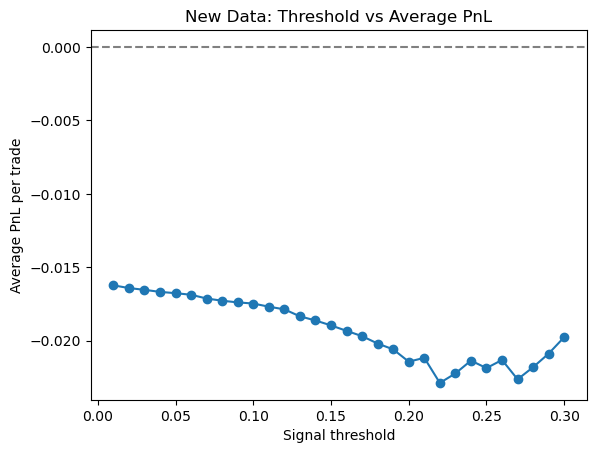

In [36]:
# Microstep: plot PnL vs threshold for the new dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

thresholds = np.linspace(0.01, 0.30, 30)
results_new = []

for t in thresholds:
    # Decide position based on threshold
    pos = np.select(
        [crypto_new["signal_diff"] > t, crypto_new["signal_diff"] < -t],
        ["LONG_YES", "LONG_NO"],
        default="NO_TRADE"
    )

    # Compute pnl for these positions
    pnl = crypto_new.copy()
    pnl["position_tmp"] = pos
    pnl["pnl_tmp"] = pnl.apply(compute_pnl, axis=1)

    results_new.append({
        "threshold": t,
        "total_pnl": pnl["pnl_tmp"].sum(),
        "avg_pnl": pnl.loc[pnl["position_tmp"] != "NO_TRADE", "pnl_tmp"].mean()
    })

df_results_new = pd.DataFrame(results_new)

plt.plot(df_results_new["threshold"], df_results_new["avg_pnl"], marker="o")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Signal threshold")
plt.ylabel("Average PnL per trade")
plt.title("New Data: Threshold vs Average PnL")
plt.show()


In [37]:
# Compare simple feature→target correlations old vs new
corr_old = crypto_old[X_cols_v5 + ["is_yes"]].corr()["is_yes"].drop("is_yes")
corr_new = crypto_new[X_cols_v5 + ["is_yes"]].corr()["is_yes"].drop("is_yes")

pd.DataFrame({"old_corr": corr_old, "new_corr": corr_new, "change": corr_new - corr_old}).sort_values("change")


,old_corr,new_corr,change
vol_surge_3m,0.070734,-0.011444,-0.082178
ratio_vol_1m_30m,0.169926,0.103023,-0.066902
accel_ratio,-0.046669,-0.103954,-0.057285
price_change_1m,-0.111122,-0.142319,-0.031197
price_vol_1m_interaction,-0.119803,-0.138691,-0.018889
inter_dir_burst,-0.137856,-0.155062,-0.017207
last_minute_ratio,0.138248,0.128565,-0.009683
price_change_3m,-0.224372,-0.221969,0.002403
direction_agreement,-0.202626,-0.187578,0.015048
velocity_price_change,0.093902,0.120675,0.026773
